In [1]:
import os
import sys

sys.path.append(os.path.join("..",".."))
sys.path.append(os.path.join("..","..","..",'Data_prep'))
#sys.path.append(os.path.join(".."))

import numpy as np

import pickle
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

In [19]:
!ls ../../../Data

checker		  img_loc  ndvi			 sentera_loc
Data_prep	  Model_1  segmentation		 skipped.txt
general_analysis  Models2  segmentation_methods


In [2]:
#import Utils_imp_VAE
from B_VAE.VAE_v2 import b_encodeco

In [3]:
bce=np.load('bce_results.npy',allow_pickle=True)

In [4]:
def read_results(npy,fold):
    train=npy.tolist()[fold]['train']
    test=npy.tolist()[fold]['valid']
    return train,test

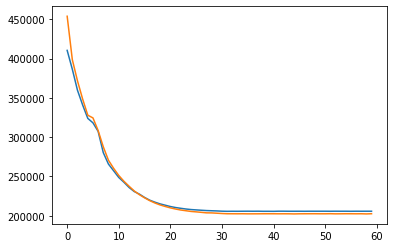

In [5]:
train,test=read_results(np.load('bce_results.npy',allow_pickle=True),0)
train1,test1=read_results(np.load('bce_results.npy',allow_pickle=True),1)

plt.plot(test+test1)
plt.plot(train+train1)

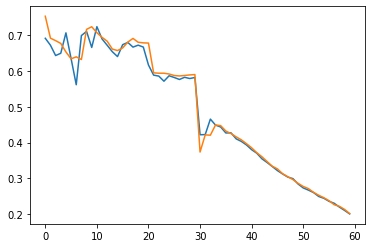

In [6]:
train,test=read_results(np.load('kld_results.npy',allow_pickle=True),0)
train1,test1=read_results(np.load('kld_results.npy',allow_pickle=True),1)

plt.plot(test+test1)
plt.plot(train+train1)

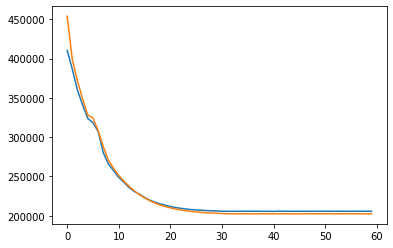

In [7]:
train,test=read_results(np.load('loss_results.npy',allow_pickle=True),0)
train1,test1=read_results(np.load('loss_results.npy',allow_pickle=True),1)

plt.plot(test+test1)
plt.plot(train+train1)

In [3]:
a=torch.load('best1.pt')

In [4]:
model=b_encodeco(image_dim=int(100),
                 image_channels=3,
                 repr_sizes=[5,8,10],
                 layer_sizes=[100],
                 latent_space_size=20,
                 conv_kernel_size=15,
                 conv_pooling=False,
                 conv_batch_norm=True,
                 NN_batch_norm=True,
                 stride=2,
                device='cuda')

In [5]:
model.load_state_dict(a)

<All keys matched successfully>

In [6]:
model.eval()

b_encodeco(
  (encoder_conv): b_encoder_conv(
    (im_layers): ModuleList(
      (0): set_conv(
        (comp_layer): ModuleList(
          (0): Conv2d(3, 5, kernel_size=(15, 15), stride=(1, 1))
          (1): ReLU()
          (2): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): set_conv(
        (comp_layer): ModuleList(
          (0): Conv2d(5, 8, kernel_size=(15, 15), stride=(1, 1))
          (1): ReLU()
          (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): set_conv(
        (comp_layer): ModuleList(
          (0): Conv2d(8, 10, kernel_size=(15, 15), stride=(1, 1))
          (1): ReLU()
          (2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
  )
  (encoder_NN_mu): NeuralNet(
    (layers): ModuleList(
      (0): Sequential(
        (0): NN_layer(
          (layer): ModuleList(
            (0): L

In [7]:
from torchvision import transforms
from Custom_dataloader import *
from Transforms import phantom_segmentation
from Transforms import phantom_segmentation_
from Transforms import multi_image_resize
from Transforms import multi_ToTensor
from Transforms import output_transform
from Transforms import rgb_normalize

DB="/run/user/1000/gvfs/afp-volume:host=MyCloudPR4100.local,user=aorus_1,volume=Paltas_DataBase/Data_Base_v2"

d_tt=transforms.Compose([
        phantom_segmentation_(False),
        rgb_normalize(ImType=['PhantomRGB']),
        multi_image_resize(ImType=['PhantomRGB'],size=(100,100)),
        multi_ToTensor(ImType=['PhantomRGB']),
        #output_transform()
        ])

datab=Dataset_direct(root_dir=DB,ImType=['PhantomRGB'],Intersec=False,transform=d_tt)

In [10]:
img=datab[100]

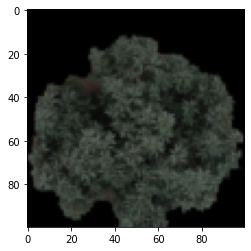

In [30]:
i=img['PhantomRGB']
ir=np.dstack([i[0,:,:],i[1,:,:],i[2,:,:]])
plt.imshow(ir)

In [11]:
print(model.encoder_conv.im_layers)
model.to('cpu')
fl=model.encoder_conv(torch.unsqueeze(img['PhantomRGB'], 0))
fl_=model.flatten(fl)
fl_u=model.encoder_NN_mu(fl_)
fl_sig=model.encoder_NN_sig(fl_)

ModuleList(
  (0): set_conv(
    (comp_layer): ModuleList(
      (0): Conv2d(3, 5, kernel_size=(15, 15), stride=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): set_conv(
    (comp_layer): ModuleList(
      (0): Conv2d(5, 8, kernel_size=(15, 15), stride=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): set_conv(
    (comp_layer): ModuleList(
      (0): Conv2d(8, 10, kernel_size=(15, 15), stride=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
)


0


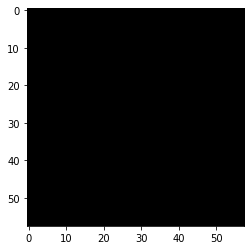

1


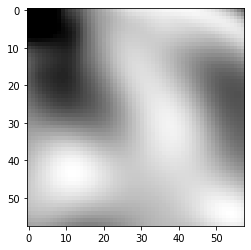

2


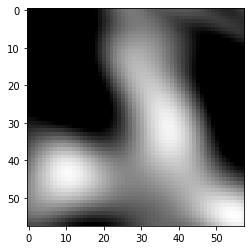

3


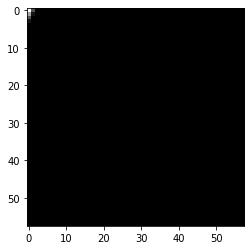

4


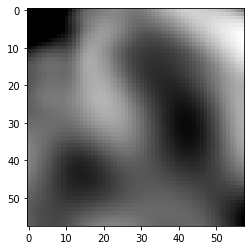

5


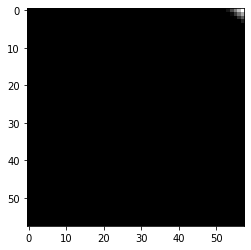

6


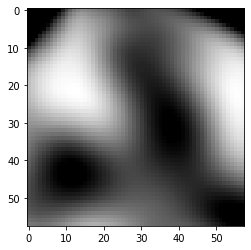

7


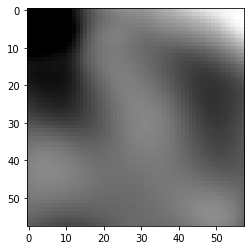

8


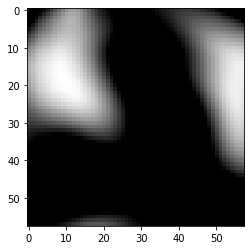

9


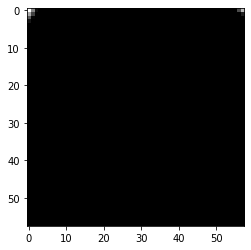

In [12]:
for i in range(10):
    print(i)
    plt.imshow(fl[0,i,:,:].detach().numpy(),cmap='gray')
    plt.show()
#plt.imshow(fl[0,0,:,:].detach().numpy())
#fl[0,0,:,:].detach().numpy().shape

In [33]:
model.to('cuda')
io=model(torch.unsqueeze(img['PhantomRGB'], 0).to('cuda'))

In [34]:
io=io[0].to('cpu').detach().numpy()

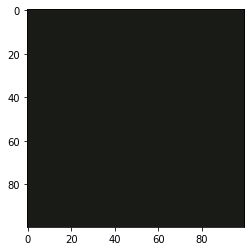

In [35]:
io=io[0,:,:,:]
ir=np.dstack([io[0,:,:],io[1,:,:],io[2,:,:]])
plt.imshow(ir)

In [36]:
model.to('cpu')
fl=model.encoder_conv(torch.unsqueeze(img['PhantomRGB'], 0))
fl_=model.flatten(fl)
fl_u=model.encoder_NN_mu(fl_)
fl_sig=model.encoder_NN_sig(fl_)

array([[0.1086854, 0.1086854, 0.1086854, ..., 0.1086854, 0.1086854,
        0.1086854],
       [0.1086854, 0.1086854, 0.1086854, ..., 0.1086854, 0.1086854,
        0.1086854],
       [0.1086854, 0.1086854, 0.1086854, ..., 0.1086854, 0.1086854,
        0.1086854],
       ...,
       [0.1086854, 0.1086854, 0.1086854, ..., 0.1086854, 0.1086854,
        0.1086854],
       [0.1086854, 0.1086854, 0.1086854, ..., 0.1086854, 0.1086854,
        0.1086854],
       [0.1086854, 0.1086854, 0.1086854, ..., 0.1086854, 0.1086854,
        0.1086854]], dtype=float32)

In [20]:
dataloader_eval=torch.utils.data.DataLoader(datab,
                                             batch_size=1,
                                             shuffle=False,
                                             num_workers=1,
                                             drop_last=False)

meta_dir="/run/user/1000/gvfs/afp-volume:host=MyCloudPR4100.local,user=aorus_1,volume=Paltas_DataBase/metadata_VAE_v2"

In [47]:
for idx, batch in tqdm(enumerate(dataloader_eval),desc="latent_vars"):
    latent_metadata={}
    model.to('cpu')
    fl=model.encoder_conv(batch['PhantomRGB'])
    fl_=model.flatten(fl)
    fl_u=model.encoder_NN_mu(fl_)
    fl_sig=model.encoder_NN_sig(fl_)
    latent_metadata['u']=fl_u.detach().numpy()
    latent_metadata['sig']=fl_sig.detach().numpy()
    latent_metadata['Place']=batch['Place']
    latent_metadata['Date']=batch['Date']
    latent_metadata['Class']=batch['landmarks']
    
    file=open(os.path.join(meta_dir,(batch['Date'][0]+'_'+batch['Place'][0]+'.pkl')),'wb')
    pickle.dump(latent_metadata,file)
    file.close()

        
    tqdm.write(
            "Place {loss}\tDate {bce}\tClass {kld}".format(
                loss=batch['Place'][0],
                bce=batch['Date'][0],
                kld=batch['landmarks'][0]
        )
        )
        
        #SAVE DATA

latent_vars: 1it [00:14, 14.03s/it]

Place 10_A	Date 11_junio_1	Class N_Control


latent_vars: 2it [00:26, 12.91s/it]

Place 10_B	Date 11_junio_1	Class P_Control


latent_vars: 3it [00:38, 12.59s/it]

Place 10_C	Date 11_junio_1	Class K_Control


latent_vars: 3it [00:50, 16.69s/it]


In [49]:
os.listdir(meta_dir)[1:]

['11_junio_110_A.pkl',
 '11_junio_110_B.pkl',
 '11_junio_110_C.pkl',
 '11_junio_110_D.pkl',
 '11_junio_1_10_A.pkl',
 '11_junio_1_10_B.pkl',
 '11_junio_1_10_C.pkl',
 '11_junio_1_10_D.pkl']

In [50]:
meta=np.array(os.listdir(meta_dir)[1:])

In [53]:
mm=np.vectorize(lambda m:pickle.load(open(os.path.join(meta_dir,m),'rb')))(meta)